### 5.2.1.1.a. Import các thư viện cần thiết

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier


#### 5.2.1.1.b. Đọc dữ liệu

In [2]:
data = pd.read_csv('NASA_Near_Earth_Objects.csv')

#### 5.2.1.2. Thống kê mô tả bộ dữ liệu

In [3]:
data.describe()

,Unnamed: 0,id,neo_reference_id,absolute_magnitude_h,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,perihelion_distance,aphelion_distance
count,24000.000000,2.400000e+04,2.400000e+04,23992.000000,23992.000000,23992.000000,24000.000000,24000.000000
mean,11999.500000,7.275111e+06,7.275111e+06,22.942274,0.167777,0.375160,0.915225,2.653104
std,6928.347566,1.333987e+07,1.333987e+07,2.952871,0.293000,0.655169,0.232201,4.468233
min,0.000000,2.001981e+06,2.001981e+06,12.580000,0.000609,0.001362,0.070431,0.653754
25%,5999.750000,3.409962e+06,3.409962e+06,20.650000,0.024241,0.054205,0.785150,1.706281
50%,11999.500000,3.703790e+06,3.703790e+06,23.200000,0.060891,0.136157,0.965325,2.480109
75%,17999.250000,3.803897e+06,3.803897e+06,25.200000,0.197040,0.440595,1.068984,3.397965
max,23999.000000,5.408749e+07,5.408749e+07,33.200000,8.101305,18.115068,1.299988,631.895456


#### 5.2.2.1. Kiểm tra thông tin bộ dữ liệu

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         24000 non-null  int64  
 1   id                                 24000 non-null  int64  
 2   neo_reference_id                   24000 non-null  int64  
 3   name                               24000 non-null  object 
 4   name_limited                       144 non-null    object 
 5   designation                        24000 non-null  object 
 6   absolute_magnitude_h               23992 non-null  float64
 7   is_potentially_hazardous_asteroid  24000 non-null  bool   
 8   is_sentry_object                   24000 non-null  bool   
 9   kilometers_estimated_diameter_min  23992 non-null  float64
 10  kilometers_estimated_diameter_max  23992 non-null  float64
 11  orbit_id                           24000 non-null  obj

In [5]:
print(f"Số lượng hàng và cột: ({data.shape[0]}, {data.shape[1]})")

Số lượng hàng và cột: (24000, 18)


### 5.2.2.2. Tính số lượng dữ liệu bị khuyết, trùng

In [6]:
duplicate_rows = data.duplicated().sum()
print(f"Số lượng dữ liệu trùng lặp: {duplicate_rows}")

null_values = data.isnull().sum().sum()
print(f"Số lượng dữ liệu bị khuyết: {null_values}")

Số lượng dữ liệu trùng lặp: 0
Số lượng dữ liệu bị khuyết: 23880


In [7]:
null_values_per_column = data.isnull().sum()
print(null_values_per_column)

Unnamed: 0                               0
id                                       0
neo_reference_id                         0
name                                     0
name_limited                         23856
designation                              0
absolute_magnitude_h                     8
is_potentially_hazardous_asteroid        0
is_sentry_object                         0
kilometers_estimated_diameter_min        8
kilometers_estimated_diameter_max        8
orbit_id                                 0
orbit_class_type                         0
perihelion_distance                      0
aphelion_distance                        0
first_observation_date                   0
last_observation_date                    0
orbit_class_description                  0
dtype: int64


### 5.3. Phân tích khám phá dữ liệu và kỹ thuật đặc trưng

In [8]:
cat_features = []
num_features = []
cols_to_drop = []

#### 5.3.1.1. is_potentially_hazardous_asteroid

In [9]:
percentage_hazardous = data['is_potentially_hazardous_asteroid'].value_counts(normalize=True) * 100
percentage_hazardous = percentage_hazardous.astype(str) + '%'
print(percentage_hazardous)

is_potentially_hazardous_asteroid
False    91.27499999999999%
True                 8.725%
Name: proportion, dtype: object


In [10]:
data['last_observation_date'] = pd.to_datetime(data['last_observation_date'])

data = data[
    ((data['is_potentially_hazardous_asteroid'] == True) |
     ((data['is_potentially_hazardous_asteroid'] == False) & (data['last_observation_date'].dt.year >= 2021)))]

print(f"Số lượng hàng và cột: ({data.shape[0]}, {data.shape[1]})")

Số lượng hàng và cột: (4568, 18)


In [11]:
percentage_hazardous = data['is_potentially_hazardous_asteroid'].value_counts(normalize=True) * 100
percentage_hazardous = percentage_hazardous.astype(str) + '%'
print(percentage_hazardous)

is_potentially_hazardous_asteroid
False    54.159369527145365%
True      45.84063047285464%
Name: proportion, dtype: object


C:\Users\Admin\AppData\Local\Temp\ipykernel_268\3591721938.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hazardous_counts.index, y=hazardous_counts.values, palette='viridis')


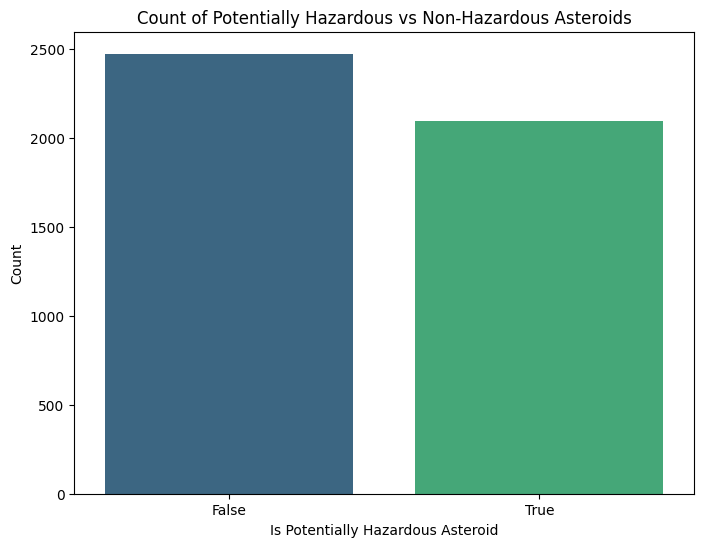

In [12]:
hazardous_counts = data['is_potentially_hazardous_asteroid'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=hazardous_counts.index, y=hazardous_counts.values, palette='viridis')
plt.xlabel('Is Potentially Hazardous Asteroid')
plt.ylabel('Count')
plt.title('Count of Potentially Hazardous vs Non-Hazardous Asteroids')
plt.xticks([0, 1], ['False', 'True'])
plt.show()

In [13]:
cat_features.append('is_potentially_hazardous_asteroid')

#### 5.3.1.2. id

In [14]:
correlation, p_value = pearsonr(data['id'], data['is_potentially_hazardous_asteroid'].astype(int))
print(f"Mức độ tương quan giữa 'id' và 'is_potentially_hazardous_asteroid': {correlation}")
print(f"P-value: {p_value}")

Mức độ tương quan giữa 'id' và 'is_potentially_hazardous_asteroid': -0.016519023973482698
P-value: 0.2643187476430615


In [15]:
cols_to_drop.append('id')

#### 5.3.1.3. neo_reference_id

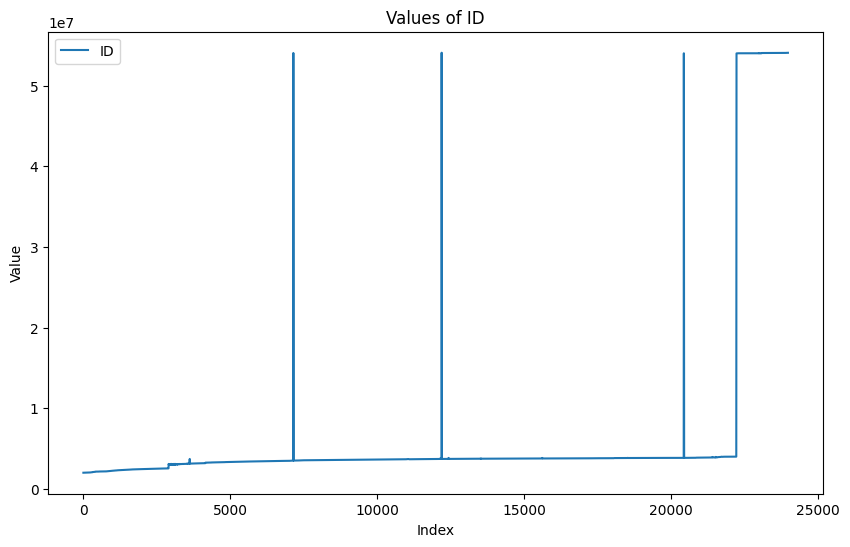

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(data['id'], label='ID')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Values of ID')
plt.legend()
plt.show()

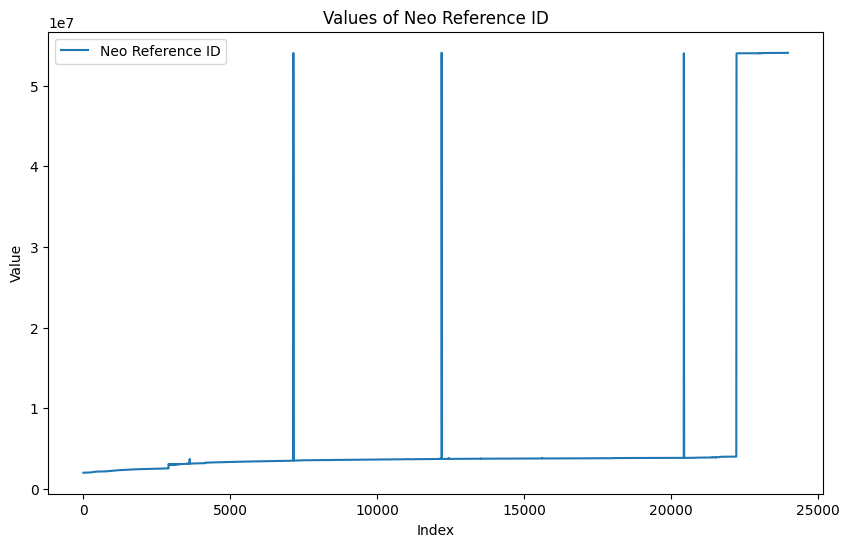

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(data['neo_reference_id'], label='Neo Reference ID')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Values of Neo Reference ID')
plt.legend()
plt.show()

In [18]:
cols_to_drop.append('neo_reference_id')

#### 5.3.1.4. name

In [19]:
label_encoder = LabelEncoder()
# Số hóa cột 'name'
data['name_encoded'] = label_encoder.fit_transform(data['name'].astype(str))

correlation_name, p_value = pearsonr(data['name_encoded'], data['is_potentially_hazardous_asteroid'].astype(int))

print(f"Mối tương quan giữa 'name' và 'is_potentially_hazardous_asteroid': {correlation_name}")
print(f"P-value: {p_value}")

Mối tương quan giữa 'name' và 'is_potentially_hazardous_asteroid': -0.1115380080468996
P-value: 4.0290338110826633e-14


In [20]:
cols_to_drop.append('name')

#### 5.3.1.5. name_limited

In [21]:
print(data[['name', 'name_limited']].head())

                         name name_limited
0        1981 Midas (1973 EA)        Midas
1  2059 Baboquivari (1963 UA)  Baboquivari
2         2061 Anza (1960 UA)         Anza
4      2063 Bacchus (1977 HB)      Bacchus
5    2100 Ra-Shalom (1978 RA)    Ra-Shalom


In [22]:
cols_to_drop.append('name_limited')

#### 5.3.1.6. designation

In [23]:
print(data[['name', 'designation']].head())

                         name designation
0        1981 Midas (1973 EA)        1981
1  2059 Baboquivari (1963 UA)        2059
2         2061 Anza (1960 UA)        2061
4      2063 Bacchus (1977 HB)        2063
5    2100 Ra-Shalom (1978 RA)        2100


In [24]:
cols_to_drop.append('designation')

#### 5.3.1.7. absolute_magnitude_h

In [25]:
correlation, p_value = pearsonr(data['absolute_magnitude_h'], data['is_potentially_hazardous_asteroid'].astype(int))
print(f"Mối tương quan giữa 'absolute_magnitude_h' và 'is_potentially_hazardous_asteroid': {correlation}")
print(f"P-value: {p_value}")

Mối tương quan giữa 'absolute_magnitude_h' và 'is_potentially_hazardous_asteroid': 0.13058974594758763
P-value: 7.878733179233021e-19


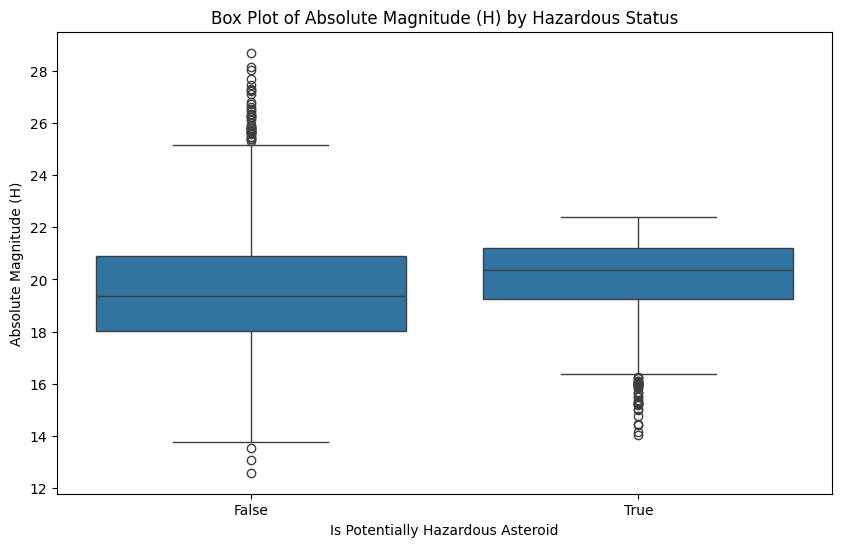

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_potentially_hazardous_asteroid', y='absolute_magnitude_h', data=data)
plt.xlabel('Is Potentially Hazardous Asteroid')
plt.ylabel('Absolute Magnitude (H)')
plt.title('Box Plot of Absolute Magnitude (H) by Hazardous Status')
plt.xticks([0, 1], ['False', 'True'])
plt.show()

In [27]:
num_features.append('absolute_magnitude_h')

#### 5.3.1.8. is_sentry_object

In [28]:
correlation, p_value = pearsonr(data['is_sentry_object'], data['is_potentially_hazardous_asteroid'].astype(int))
print(f"Mối tương quan giữa 'is_sentry_object' và 'is_potentially_hazardous_asteroid': {correlation}")
print(f"P-value: {p_value}")

Mối tương quan giữa 'is_sentry_object' và 'is_potentially_hazardous_asteroid': 0.04720075745297552
P-value: 0.0014175077773528092


C:\Users\Admin\AppData\Local\Temp\ipykernel_268\4149389013.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentry_counts.index, y=sentry_counts.values, palette='viridis')


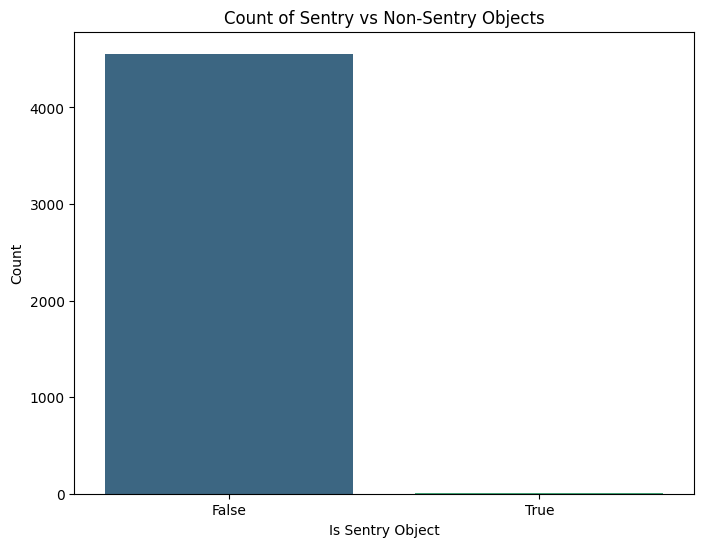

In [29]:
sentry_counts = data['is_sentry_object'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentry_counts.index, y=sentry_counts.values, palette='viridis')
plt.xlabel('Is Sentry Object')
plt.ylabel('Count')
plt.title('Count of Sentry vs Non-Sentry Objects')
plt.xticks([0, 1], ['False', 'True'])
plt.show()

In [30]:
sentry_data = data[data['is_sentry_object'] == True]

hazardous_count = sentry_data[sentry_data['is_potentially_hazardous_asteroid'] == True].shape[0]
non_hazardous_count = sentry_data[sentry_data['is_potentially_hazardous_asteroid'] == False].shape[0]

print(f"Số lượng NEO thuộc hệ thống theo dõi Sentry: {sentry_data.shape[0]}")
print(f"Số lượng NEO Sentry gây nguy hiểm tiềm tàng: {hazardous_count}")
print(f"Số lượng NEO Sentry không gây nguy hiểm tiềm tàng: {non_hazardous_count}")

Số lượng NEO thuộc hệ thống theo dõi Sentry: 12
Số lượng NEO Sentry gây nguy hiểm tiềm tàng: 11
Số lượng NEO Sentry không gây nguy hiểm tiềm tàng: 1


In [31]:
cat_features.append('is_sentry_object')

#### 5.3.1.9. kilometers_estimated_diameter_min

In [32]:
null_kilo_min_data = data[data['kilometers_estimated_diameter_min'].isnull()][['id', 'kilometers_estimated_diameter_min', 'kilometers_estimated_diameter_max']]

print(null_kilo_min_data)

num_null_kilo_min = null_kilo_min_data.shape[0]
print(f"Number of rows where 'kilometers_estimated_diameter_min' is null: {num_null_kilo_min}")

           id  kilometers_estimated_diameter_min  \
7098  3486442                                NaN   
7398  3536555                                NaN   

      kilometers_estimated_diameter_max  
7098                                NaN  
7398                                NaN  
Number of rows where 'kilometers_estimated_diameter_min' is null: 2


In [33]:
data = data.dropna(subset=['kilometers_estimated_diameter_min'])

correlation, p_value = pearsonr(data['kilometers_estimated_diameter_min'], data['is_potentially_hazardous_asteroid'].astype(int))
print(f"Mối tương quan giữa 'kilometers_estimated_diameter_min' and 'is_potentially_hazardous_asteroid': {correlation}")
print(f"P-value: {p_value}")

Mối tương quan giữa 'kilometers_estimated_diameter_min' and 'is_potentially_hazardous_asteroid': -0.19395689350264447
P-value: 6.022811537431043e-40


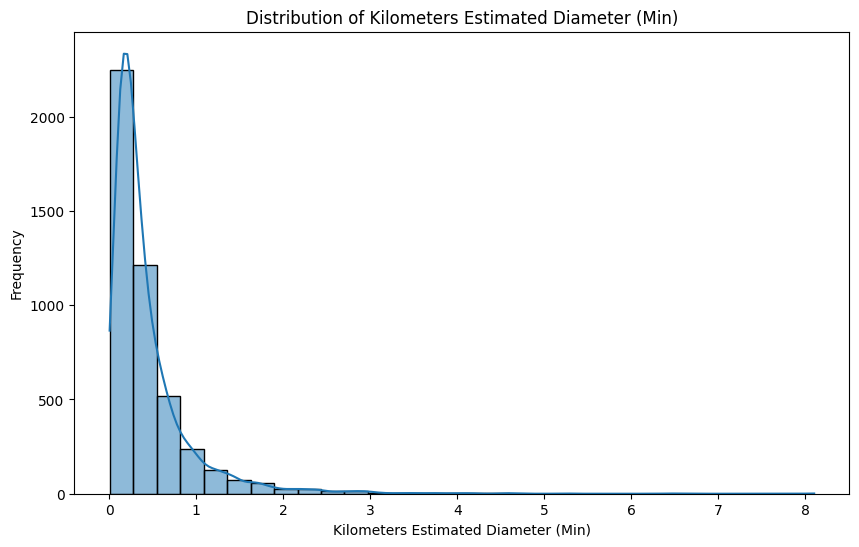

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(data['kilometers_estimated_diameter_min'], bins=30, kde=True)
plt.xlabel('Kilometers Estimated Diameter (Min)')
plt.ylabel('Frequency')
plt.title('Distribution of Kilometers Estimated Diameter (Min)')
plt.show()

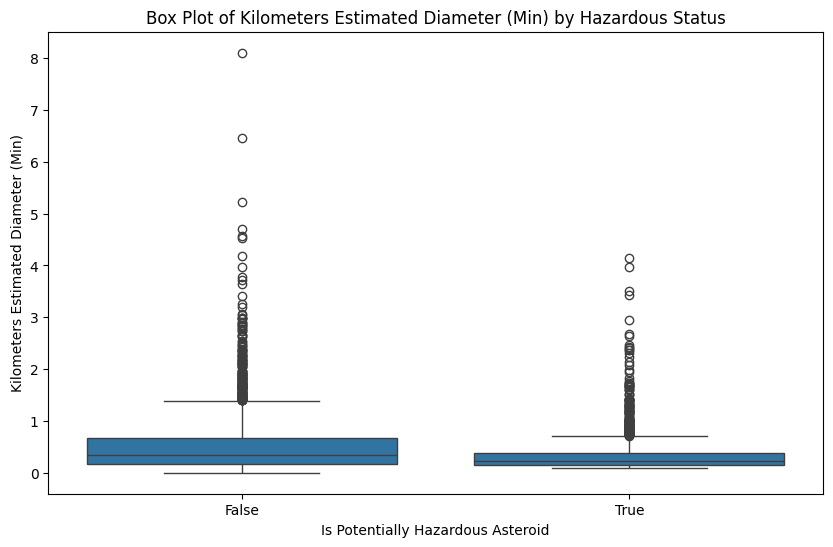

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_potentially_hazardous_asteroid', y='kilometers_estimated_diameter_min', data=data)
plt.xlabel('Is Potentially Hazardous Asteroid')
plt.ylabel('Kilometers Estimated Diameter (Min)')
plt.title('Box Plot of Kilometers Estimated Diameter (Min) by Hazardous Status')
plt.xticks([0, 1], ['False', 'True'])
plt.show()

In [36]:
num_features.append('kilometers_estimated_diameter_min')

#### 5.1.9.10. kilometers_estimated_diameter_max

In [37]:
null_kilo_max_data = data[data['kilometers_estimated_diameter_max'].isnull()][['id', 'kilometers_estimated_diameter_min', 'kilometers_estimated_diameter_max']]

print(null_kilo_max_data)

num_null_kilo_max = null_kilo_max_data.shape[0]
print(f"Number of rows where 'kilometers_estimated_diameter_max' is null: {num_null_kilo_max}")

Empty DataFrame
Columns: [id, kilometers_estimated_diameter_min, kilometers_estimated_diameter_max]
Index: []
Number of rows where 'kilometers_estimated_diameter_max' is null: 0


In [38]:
correlation, p_value = pearsonr(data['kilometers_estimated_diameter_max'], data['is_potentially_hazardous_asteroid'].astype(int))
print(f"Mối tương quan giữa 'kilometers_estimated_diameter_max' and 'is_potentially_hazardous_asteroid': {correlation}")
print(f"P-value: {p_value}")

Mối tương quan giữa 'kilometers_estimated_diameter_max' and 'is_potentially_hazardous_asteroid': -0.19395689350117495
P-value: 6.022811545618356e-40


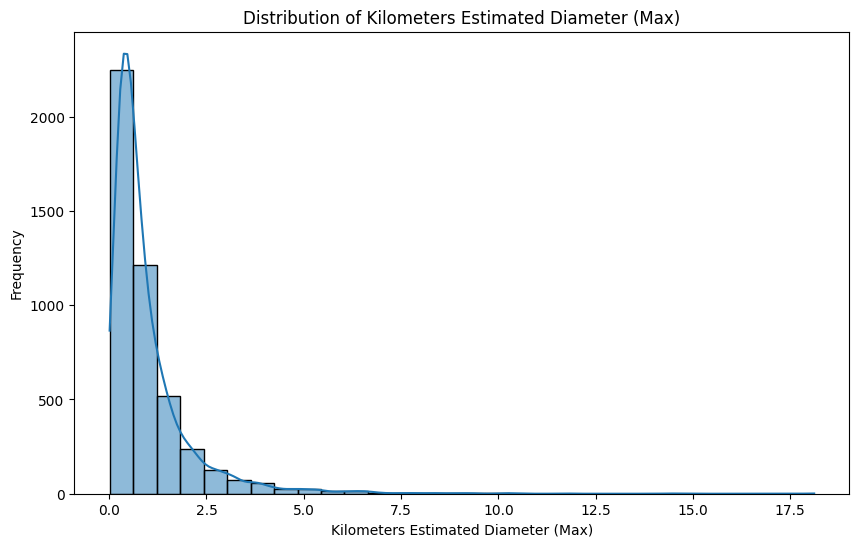

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(data['kilometers_estimated_diameter_max'], bins=30, kde=True)
plt.xlabel('Kilometers Estimated Diameter (Max)')
plt.ylabel('Frequency')
plt.title('Distribution of Kilometers Estimated Diameter (Max)')
plt.show()

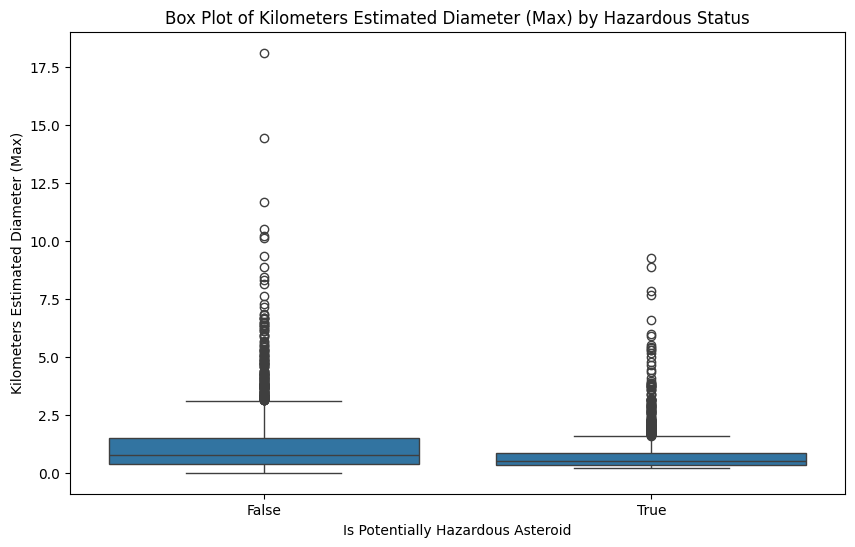

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_potentially_hazardous_asteroid', y='kilometers_estimated_diameter_max', data=data)
plt.xlabel('Is Potentially Hazardous Asteroid')
plt.ylabel('Kilometers Estimated Diameter (Max)')
plt.title('Box Plot of Kilometers Estimated Diameter (Max) by Hazardous Status')
plt.xticks([0, 1], ['False', 'True'])
plt.show()

In [41]:
num_features.append('kilometers_estimated_diameter_max')

#### 5.3.1.11. orbit_id

In [42]:
data['orbit_id_numeric'] = pd.to_numeric(data['orbit_id'], errors='coerce')

correlation, p_value = pearsonr(data['orbit_id_numeric'], data['is_potentially_hazardous_asteroid'].astype(int))
print(f"Mức độ tương quan giữa 'orbit_id' và 'is_potentially_hazardous_asteroid': {correlation}")
print(f"P-value: {p_value}")

Mức độ tương quan giữa 'orbit_id' và 'is_potentially_hazardous_asteroid': -0.12879937462755106
P-value: 2.3877752669183188e-18


C:\Users\Admin\AppData\Local\Temp\ipykernel_268\3925959772.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='orbit_id', order=data['orbit_id'].value_counts().index, palette='viridis')


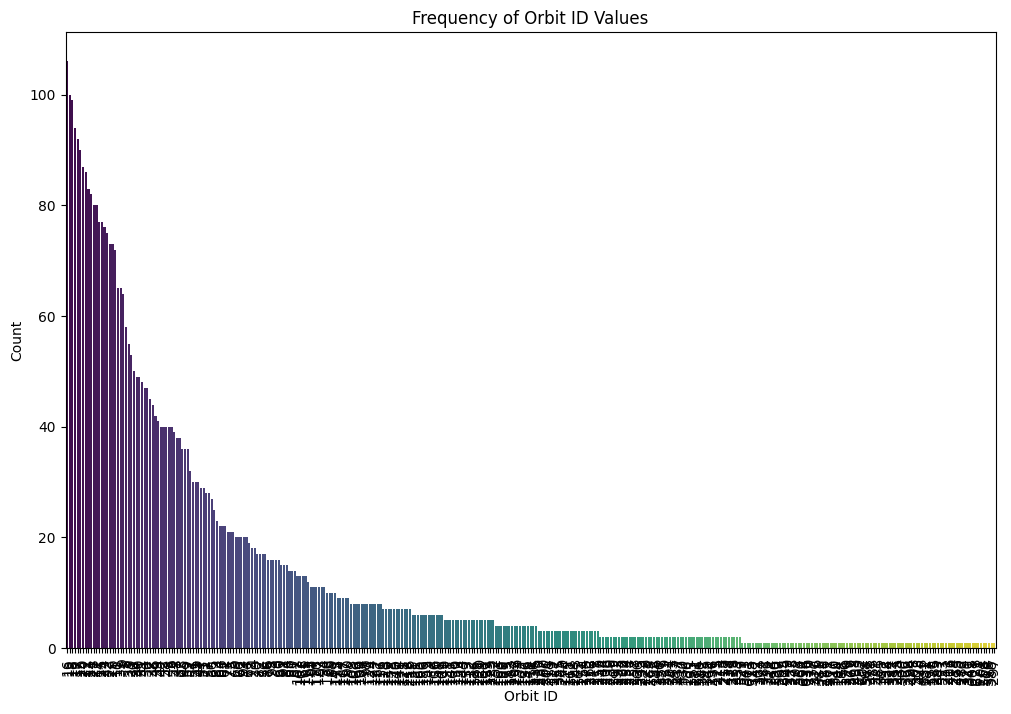

In [43]:
plt.figure(figsize=(12, 8))
sns.countplot(data=data, x='orbit_id', order=data['orbit_id'].value_counts().index, palette='viridis')
plt.xlabel('Orbit ID')
plt.ylabel('Count')
plt.title('Frequency of Orbit ID Values')
plt.xticks(rotation=90)
plt.show()

In [44]:
cols_to_drop.append('orbit_id')

#### 5.3.1.12. orbit_class_type

C:\Users\Admin\AppData\Local\Temp\ipykernel_268\1607429334.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='orbit_class_type', order=data['orbit_class_type'].value_counts().index, palette='viridis')


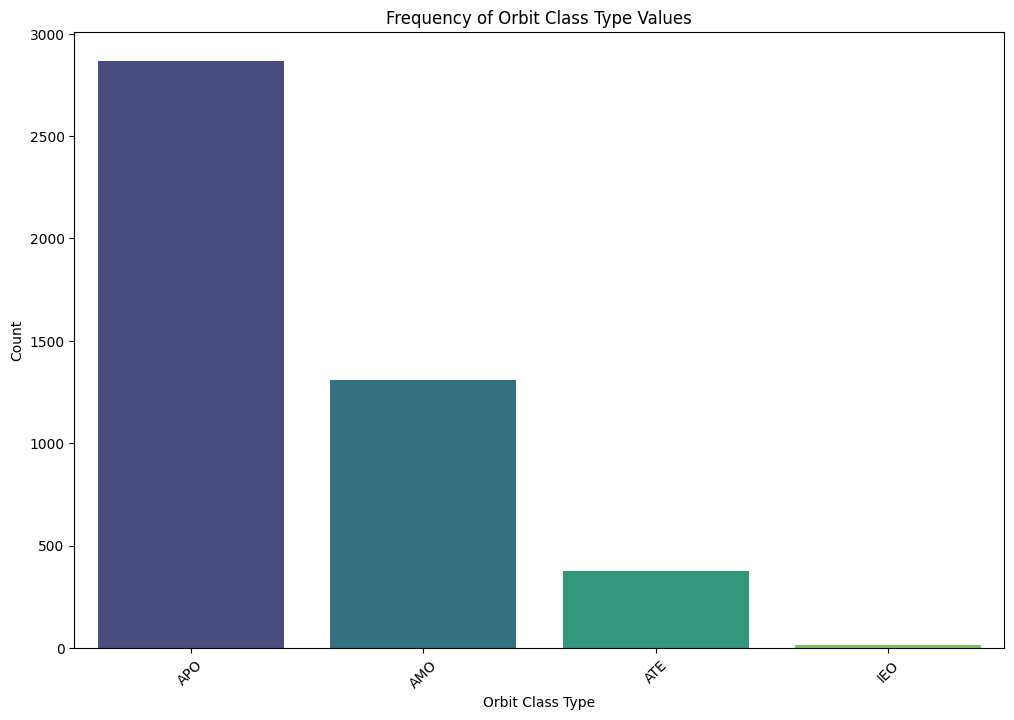

In [45]:
plt.figure(figsize=(12, 8))
sns.countplot(data=data, x='orbit_class_type', order=data['orbit_class_type'].value_counts().index, palette='viridis')
plt.xlabel('Orbit Class Type')
plt.ylabel('Count')
plt.title('Frequency of Orbit Class Type Values')
plt.xticks(rotation=45)
plt.show()

In [46]:
orbit_class_type_counts = data['orbit_class_type'].value_counts()
print(orbit_class_type_counts)

orbit_class_type
APO    2865
AMO    1307
ATE     378
IEO      16
Name: count, dtype: int64


In [47]:
label_encoder = LabelEncoder()
data['orbit_class_type_encoded'] = label_encoder.fit_transform(data['orbit_class_type'])

correlation, p_value = pearsonr(data['orbit_class_type_encoded'], data['is_potentially_hazardous_asteroid'].astype(int))
print(f"Mối tương quan giữa 'orbit_class_type' và 'is_potentially_hazardous_asteroid': {correlation}")
print(f"P-value: {p_value}")

Mối tương quan giữa 'orbit_class_type' và 'is_potentially_hazardous_asteroid': 0.359613251454326
P-value: 1.866804714821951e-139


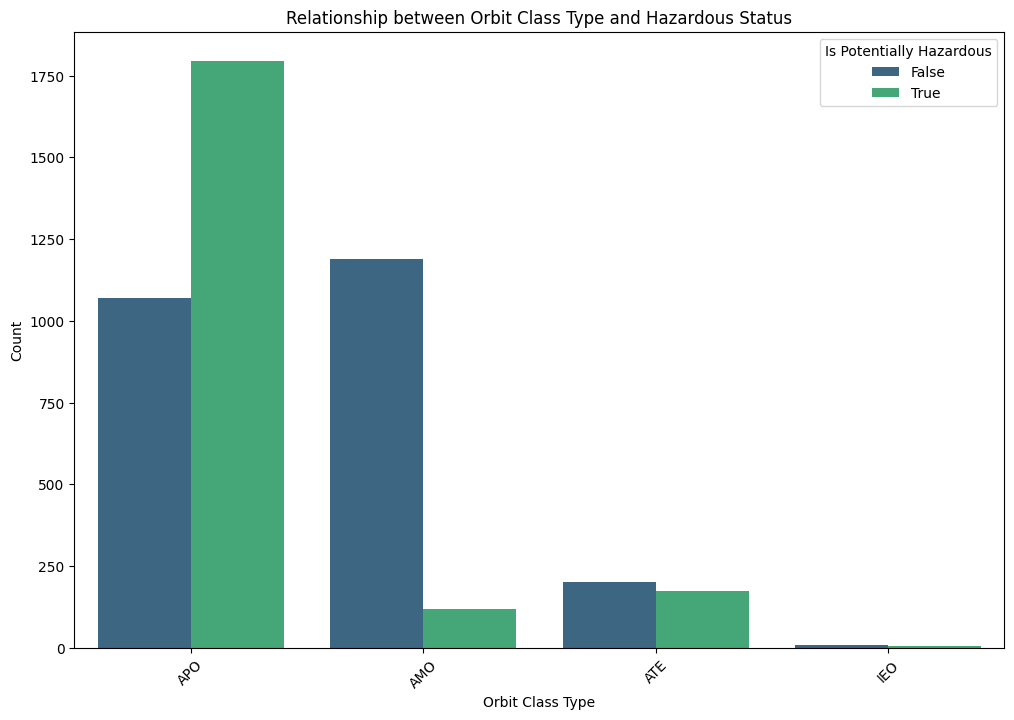

In [48]:
plt.figure(figsize=(12, 8))
sns.countplot(data=data, x='orbit_class_type', hue='is_potentially_hazardous_asteroid', palette='viridis')
plt.xlabel('Orbit Class Type')
plt.ylabel('Count')
plt.title('Relationship between Orbit Class Type and Hazardous Status')
plt.xticks(rotation=45)
plt.legend(title='Is Potentially Hazardous')
plt.show()

In [49]:
label_encoder = LabelEncoder()
data['orbit_class_type_encoded'] = label_encoder.fit_transform(data['orbit_class_type'])

In [50]:
cat_features.append('orbit_class_type_encoded')

#### 5.3.1.13. orbit_class_description

In [51]:
print(data[['orbit_class_type', 'orbit_class_description']])

      orbit_class_type                            orbit_class_description
0                  APO  Near-Earth asteroid orbits which cross the Ear...
1                  AMO  Near-Earth asteroid orbits similar to that of ...
2                  AMO  Near-Earth asteroid orbits similar to that of ...
4                  APO  Near-Earth asteroid orbits which cross the Ear...
5                  ATE  Near-Earth asteroid orbits similar to that of ...
...                ...                                                ...
23951              APO  Near-Earth asteroid orbits which cross the Ear...
23960              AMO  Near-Earth asteroid orbits similar to that of ...
23963              AMO  Near-Earth asteroid orbits similar to that of ...
23970              AMO  Near-Earth asteroid orbits similar to that of ...
23972              APO  Near-Earth asteroid orbits which cross the Ear...

[4566 rows x 2 columns]


In [52]:
cols_to_drop.append('orbit_class_description')

#### 5.3.1.14. perihelion_distance

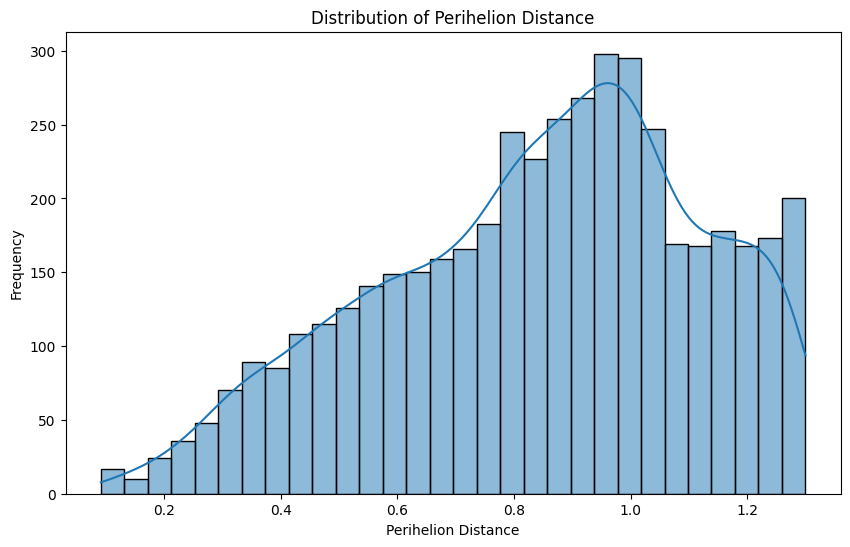

In [53]:
plt.figure(figsize=(10, 6))
sns.histplot(data['perihelion_distance'], bins=30, kde=True)
plt.xlabel('Perihelion Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Perihelion Distance')
plt.show()

In [54]:
correlation, p_value = pearsonr(data['perihelion_distance'], data['is_potentially_hazardous_asteroid'].astype(int))
print(f"Mối tương quan giữa 'perihelion_distance' và 'is_potentially_hazardous_asteroid': {correlation}")
print(f"P-value: {p_value}")

Mối tương quan giữa 'perihelion_distance' và 'is_potentially_hazardous_asteroid': -0.2757155639103028
P-value: 1.877653420450681e-80


C:\Users\Admin\AppData\Local\Temp\ipykernel_268\1213721502.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_potentially_hazardous_asteroid', y='perihelion_distance', data=data, palette='viridis')


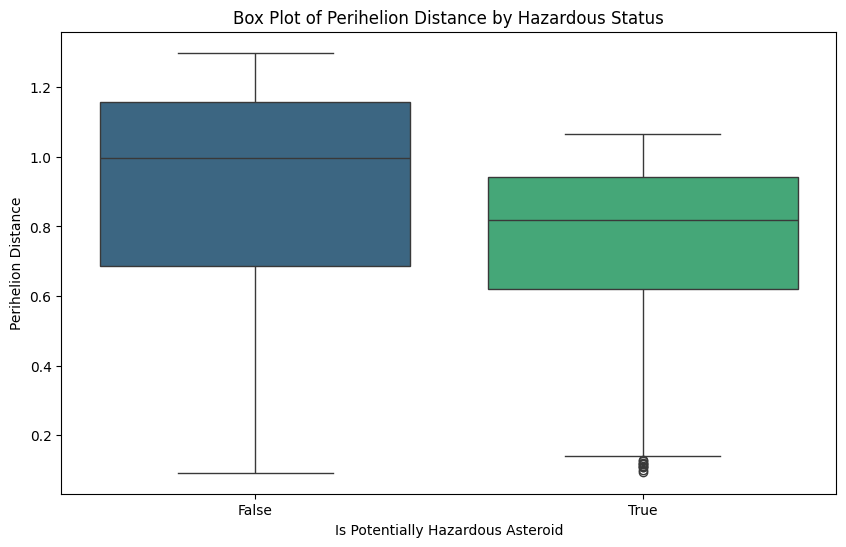

In [55]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_potentially_hazardous_asteroid', y='perihelion_distance', data=data, palette='viridis')
plt.xlabel('Is Potentially Hazardous Asteroid')
plt.ylabel('Perihelion Distance')
plt.title('Box Plot of Perihelion Distance by Hazardous Status')
plt.xticks([0, 1], ['False', 'True'])
plt.show()

In [56]:
num_features.append('perihelion_distance')

#### 5.3.1.15. aphelion_distance

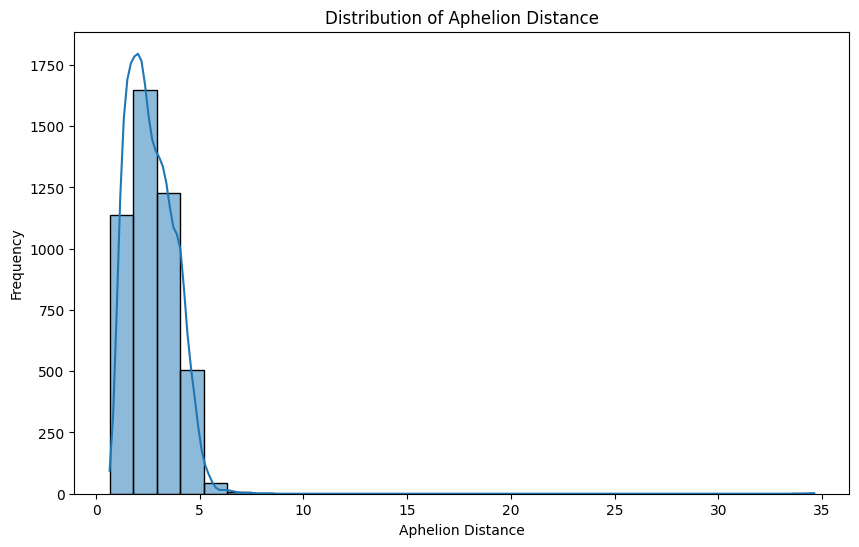

In [57]:
plt.figure(figsize=(10, 6))
sns.histplot(data['aphelion_distance'], bins=30, kde=True)
plt.xlabel('Aphelion Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Aphelion Distance')
plt.show()

In [58]:
correlation, p_value = pearsonr(data['aphelion_distance'], data['is_potentially_hazardous_asteroid'].astype(int))
print(f"Mối tương quan giữa 'aphelion_distance' và 'is_potentially_hazardous_asteroid': {correlation}")
print(f"P-value: {p_value}")

Mối tương quan giữa 'aphelion_distance' và 'is_potentially_hazardous_asteroid': 0.09608182828023844
P-value: 7.731337960143387e-11


C:\Users\Admin\AppData\Local\Temp\ipykernel_268\2328813289.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_potentially_hazardous_asteroid', y='aphelion_distance', data=data, palette='viridis')


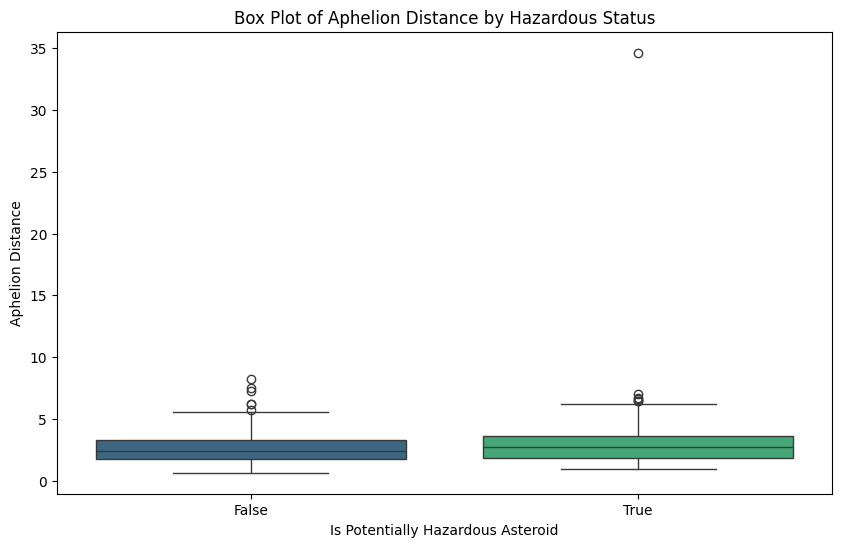

In [59]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_potentially_hazardous_asteroid', y='aphelion_distance', data=data, palette='viridis')
plt.xlabel('Is Potentially Hazardous Asteroid')
plt.ylabel('Aphelion Distance')
plt.title('Box Plot of Aphelion Distance by Hazardous Status')
plt.xticks([0, 1], ['False', 'True'])
plt.show()

In [60]:
outlier_index = data[data['is_potentially_hazardous_asteroid'] == True]['aphelion_distance'].idxmax()
data = data.drop(outlier_index)

correlation, p_value = pearsonr(data['aphelion_distance'], data['is_potentially_hazardous_asteroid'].astype(int))
print(f"Mối tương quan giữa 'aphelion_distance' và 'is_potentially_hazardous_asteroid': {correlation}")
print(f"P-value: {p_value}")

Mối tương quan giữa 'aphelion_distance' và 'is_potentially_hazardous_asteroid': 0.09791283601974254
P-value: 3.366383903968437e-11


C:\Users\Admin\AppData\Local\Temp\ipykernel_268\2328813289.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_potentially_hazardous_asteroid', y='aphelion_distance', data=data, palette='viridis')


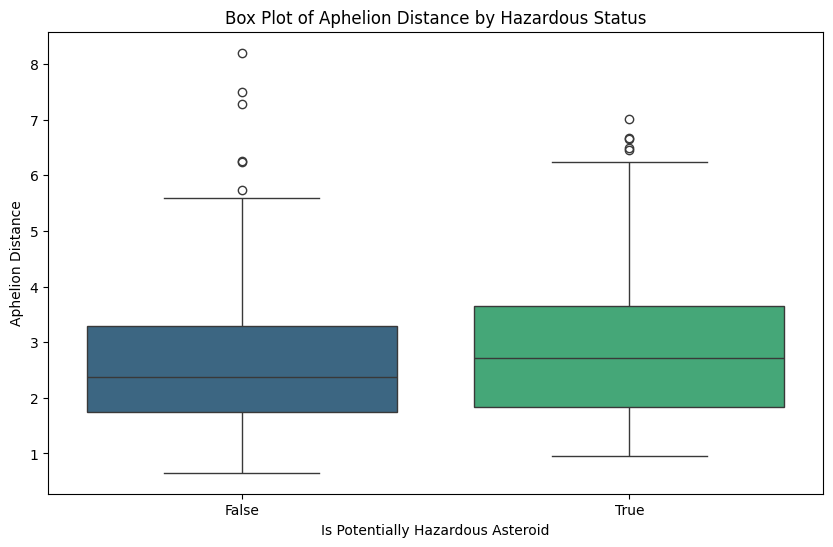

In [61]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_potentially_hazardous_asteroid', y='aphelion_distance', data=data, palette='viridis')
plt.xlabel('Is Potentially Hazardous Asteroid')
plt.ylabel('Aphelion Distance')
plt.title('Box Plot of Aphelion Distance by Hazardous Status')
plt.xticks([0, 1], ['False', 'True'])
plt.show()

In [62]:
num_features.append('aphelion_distance')

#### 5.3.1.16. first_observation_date

In [63]:
data['first_observation_date'] = pd.to_datetime(data['first_observation_date'])

data['first_observation_year'] = data['first_observation_date'].dt.year
data['first_observation_month'] = data['first_observation_date'].dt.month
data['first_observation_timestamp'] = data['first_observation_date'].astype(np.int64) // 10**9

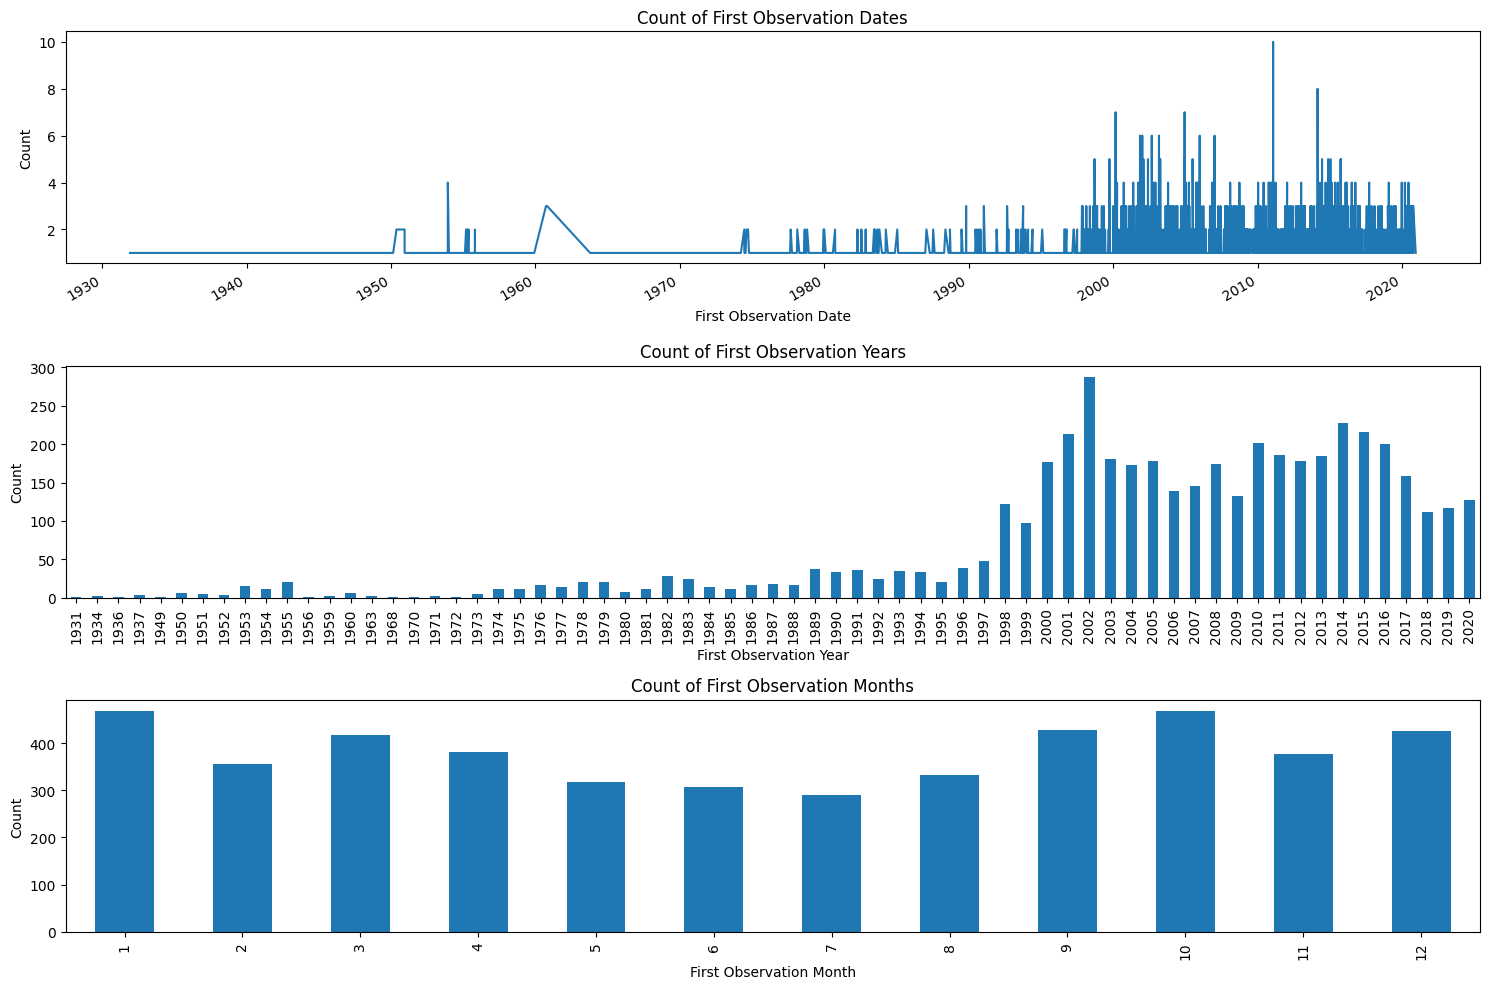

In [64]:
first_observation_date_counts = data['first_observation_date'].value_counts().sort_index()
first_observation_year_counts = data['first_observation_year'].value_counts().sort_index()
first_observation_month_counts = data['first_observation_month'].value_counts().sort_index()

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
first_observation_date_counts.plot(kind='line')
plt.xlabel('First Observation Date')
plt.ylabel('Count')
plt.title('Count of First Observation Dates')

plt.subplot(3, 1, 2)
first_observation_year_counts.plot(kind='bar')
plt.xlabel('First Observation Year')
plt.ylabel('Count')
plt.title('Count of First Observation Years')

plt.subplot(3, 1, 3)
first_observation_month_counts.plot(kind='bar')
plt.xlabel('First Observation Month')
plt.ylabel('Count')
plt.title('Count of First Observation Months')

plt.tight_layout()
plt.show()

In [65]:
correlation_date, p_value_date = pearsonr(data['first_observation_timestamp'], data['is_potentially_hazardous_asteroid'].astype(int))
correlation_year, p_value_year = pearsonr(data['first_observation_year'], data['is_potentially_hazardous_asteroid'].astype(int))
correlation_month, p_value_month = pearsonr(data['first_observation_month'], data['is_potentially_hazardous_asteroid'].astype(int))

print(f"Mối tương quan giữa 'first_observation_date' và 'is_potentially_hazardous_asteroid': {correlation_date}")
print(f"Mối tương quan giữa 'first_observation_year' và 'is_potentially_hazardous_asteroid: {correlation_year}")
print(f"Mối tương quan giữa 'first_observation_month' và 'is_potentially_hazardous_asteroid: {correlation_month}")

print(f"\nP-value (first_observation_date - is_potentially_hazardous_asteroid): {p_value_date}")
print(f"P-value (first_observation_year - is_potentially_hazardous_asteroid): {p_value_year}")
print(f"P-value (first_observation_month - is_potentially_hazardous_asteroid): {p_value_month}")

Mối tương quan giữa 'first_observation_date' và 'is_potentially_hazardous_asteroid': 0.09931216661846425
Mối tương quan giữa 'first_observation_year' và 'is_potentially_hazardous_asteroid: 0.09981531905379798
Mối tương quan giữa 'first_observation_month' và 'is_potentially_hazardous_asteroid: -0.025354339506768804

P-value (first_observation_date - is_potentially_hazardous_asteroid): 1.7583711628363984e-11
P-value (first_observation_year - is_potentially_hazardous_asteroid): 1.3891068861622293e-11
P-value (first_observation_month - is_potentially_hazardous_asteroid): 0.08673707235678876


In [66]:
cols_to_drop.append('first_observation_date')

#### 5.3.1.17. last_observation_date

In [67]:
data['last_observation_date'] = pd.to_datetime(data['last_observation_date'])

data['last_observation_year'] = data['last_observation_date'].dt.year
data['last_observation_month'] = data['last_observation_date'].dt.month
data['last_observation_timestamp'] = data['last_observation_date'].astype(np.int64) // 10**9

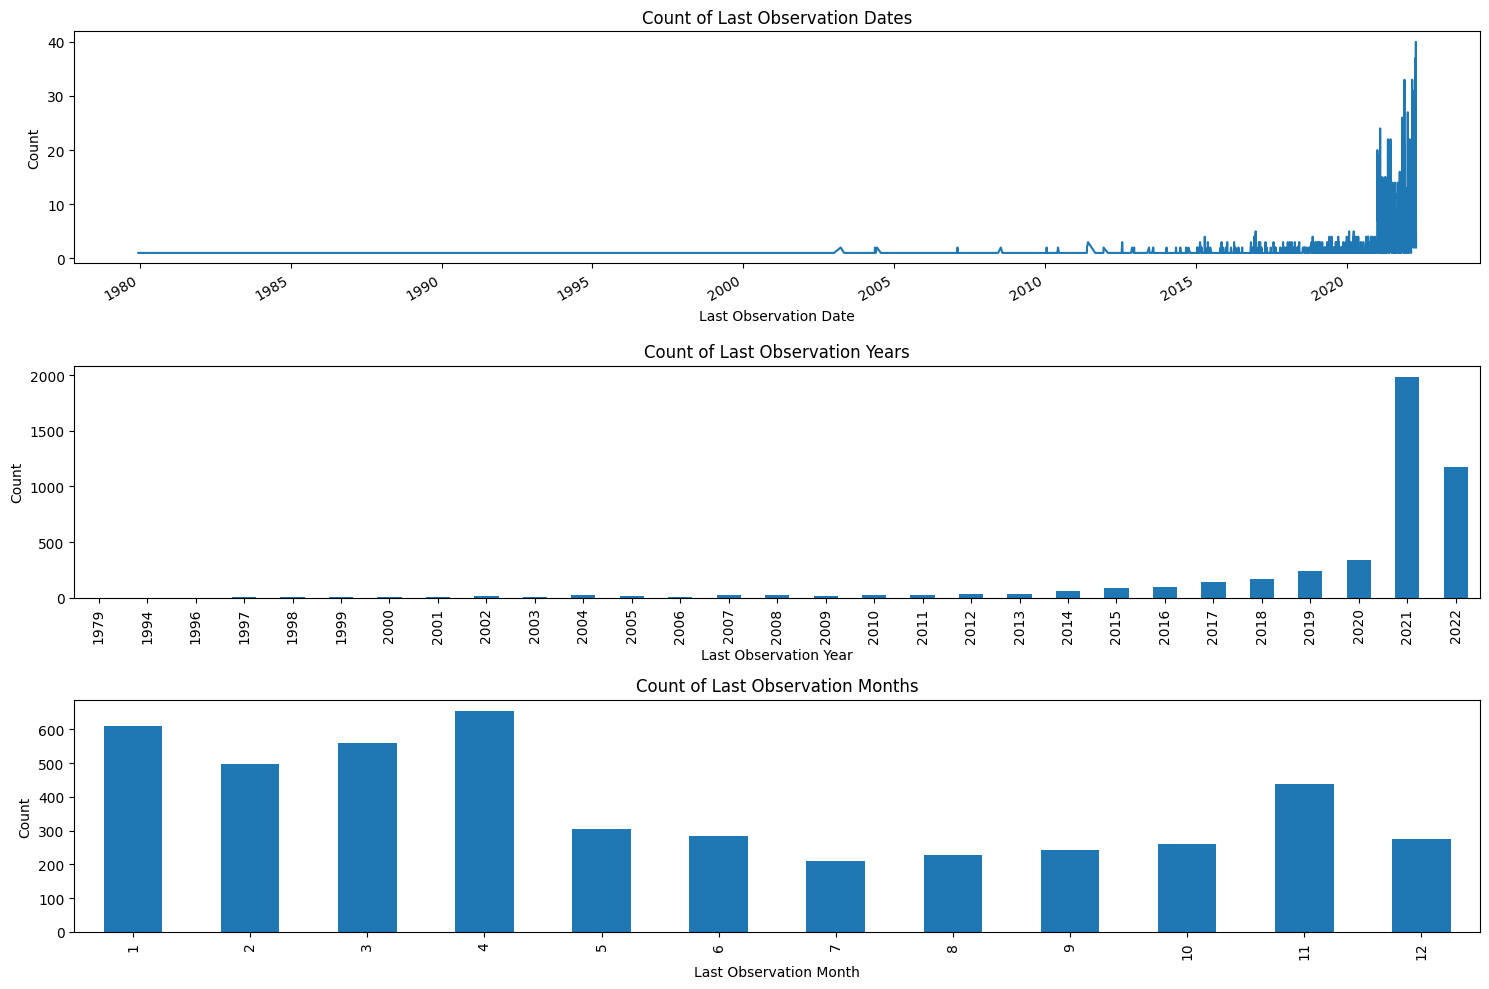

In [68]:
last_observation_date_counts = data['last_observation_date'].value_counts().sort_index()
last_observation_year_counts = data['last_observation_year'].value_counts().sort_index()
last_observation_month_counts = data['last_observation_month'].value_counts().sort_index()

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
last_observation_date_counts.plot(kind='line')
plt.xlabel('Last Observation Date')
plt.ylabel('Count')
plt.title('Count of Last Observation Dates')

plt.subplot(3, 1, 2)
last_observation_year_counts.plot(kind='bar')
plt.xlabel('Last Observation Year')
plt.ylabel('Count')
plt.title('Count of Last Observation Years')

plt.subplot(3, 1, 3)
last_observation_month_counts.plot(kind='bar')
plt.xlabel('Last Observation Month')
plt.ylabel('Count')
plt.title('Count of Last Observation Months')

plt.tight_layout()
plt.show()

In [69]:
correlation_date, p_value_date = pearsonr(data['last_observation_timestamp'], data['is_potentially_hazardous_asteroid'].astype(int))
correlation_year, p_value_year = pearsonr(data['last_observation_year'], data['is_potentially_hazardous_asteroid'].astype(int))
correlation_month, p_value_month = pearsonr(data['last_observation_month'], data['is_potentially_hazardous_asteroid'].astype(int))

print(f"Mối tương quan giữa 'last_observation_date' và 'is_potentially_hazardous_asteroid': {correlation_date}")
print(f"Mối tương quan giữa 'last_observation_year' và 'is_potentially_hazardous_asteroid': {correlation_year}")
print(f"Mối tương quan giữa 'last_observation_month' và 'is_potentially_hazardous_asteroid': {correlation_month}")

print(f"P-value (last_observation_date - is_potentially_hazardous_asteroid): {p_value_date}")
print(f"P-value (last_observation_year - is_potentially_hazardous_asteroid): {p_value_year}")
print(f"P-value (last_observation_month - is_potentially_hazardous_asteroid): {p_value_month}")

Mối tương quan giữa 'last_observation_date' và 'is_potentially_hazardous_asteroid': -0.4797593530507639
Mối tương quan giữa 'last_observation_year' và 'is_potentially_hazardous_asteroid': -0.4860726163035918
Mối tương quan giữa 'last_observation_month' và 'is_potentially_hazardous_asteroid': 0.12612109822494544
P-value (last_observation_date - is_potentially_hazardous_asteroid): 1.592199412825285e-261
P-value (last_observation_year - is_potentially_hazardous_asteroid): 2.074807582793571e-269
P-value (last_observation_month - is_potentially_hazardous_asteroid): 1.1973905580812652e-17


In [70]:
cols_to_drop.append('last_observation_date')

### 5.3.2. Lựa chọn đặc trưng

In [71]:
print(cols_to_drop)

['id', 'neo_reference_id', 'name', 'name_limited', 'designation', 'orbit_id', 'orbit_class_description', 'first_observation_date', 'last_observation_date']


In [72]:
print(cat_features)

['is_potentially_hazardous_asteroid', 'is_sentry_object', 'orbit_class_type_encoded']


In [73]:
print(num_features)

['absolute_magnitude_h', 'kilometers_estimated_diameter_min', 'kilometers_estimated_diameter_max', 'perihelion_distance', 'aphelion_distance']


In [74]:
for feature in num_features:
    data[feature] = np.log1p(data[feature])

print(data[num_features].head())

   absolute_magnitude_h  kilometers_estimated_diameter_min  \
0              2.786245                           1.224334   
1              2.831447                           0.993406   
2              2.854169                           0.884128   
4              2.905808                           0.657600   
5              2.846652                           0.919698   

   kilometers_estimated_diameter_max  perihelion_distance  aphelion_distance  
0                           1.851727             0.483359           1.368985  
1                           1.569083             0.805823           1.618981  
2                           1.429633             0.718037           1.499211  
4                           1.124893             0.531450           0.898047  
5                           1.475491             0.384412           0.786329  


In [75]:
train_features = cat_features + num_features
train_features.remove('is_potentially_hazardous_asteroid')

In [76]:
print(train_features)
print("\nNumber of features: ", len(train_features))

['is_sentry_object', 'orbit_class_type_encoded', 'absolute_magnitude_h', 'kilometers_estimated_diameter_min', 'kilometers_estimated_diameter_max', 'perihelion_distance', 'aphelion_distance']

Number of features:  7


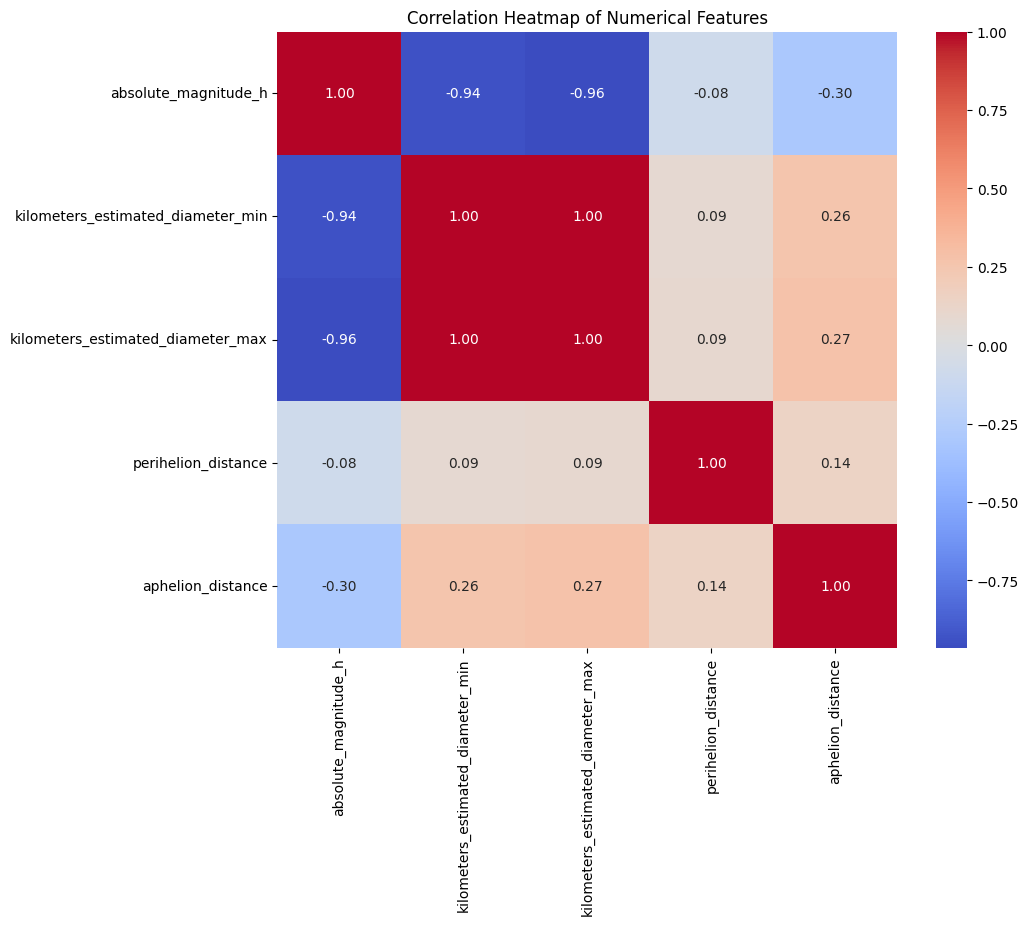

In [77]:
corr_matrix = data[num_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

### 5.4. Ứng dụng mô hình

In [78]:
X = data[train_features]
y = data['is_potentially_hazardous_asteroid']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [80]:
print('Tập huấn luyện:', X_train.shape, y_train.shape)
print('Tập kiểm tra:', X_test.shape, y_test.shape)

Tập huấn luyện: (3652, 7) (3652,)
Tập kiểm tra: (913, 7) (913,)


In [81]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_split_scaled = scaler.transform(X_train_split)
X_val_split_scaled = scaler.transform(X_val_split)

In [82]:
def tune_hyperparameters(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring='accuracy'
        )
    grid_search.fit(X_train, y_train)
    
    print(f"Các parameters hoạt động tốt nhất: {grid_search.best_params_}")
    print(f"Độ chính xác đối với các parameters tốt nhất: {grid_search.best_score_:.2f}")
    print()
    
    return grid_search.best_estimator_

In [83]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

In [84]:
def evaluate_model2(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test = y_test.astype(int)
    y_pred = y_pred.astype(int)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared: {r_squared}")
    print(f"Accuracy: {accuracy}")

#### 5.4.2. Mô hình Random Forest

In [85]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

print("Đánh giá mô hình RandomForestClassifier:")
evaluate_model(rf_model, X_test, y_test)
print()
evaluate_model2(rf_model, X_test, y_test)

Đánh giá mô hình RandomForestClassifier:
Accuracy: 0.77
Precision: 0.77
Recall: 0.77
Confusion Matrix:
[[372 110]
 [ 98 333]]
Classification Report:
              precision    recall  f1-score   support

       False       0.79      0.77      0.78       482
        True       0.75      0.77      0.76       431

    accuracy                           0.77       913
   macro avg       0.77      0.77      0.77       913
weighted avg       0.77      0.77      0.77       913


Mean Squared Error (MSE): 0.22782037239868566
Root Mean Squared Error (RMSE): 0.47730532408374166
Mean Absolute Error (MAE): 0.22782037239868566
R-squared: 0.08586612240182545
Accuracy: 0.7721796276013143


In [86]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [87]:
best_rf_model = tune_hyperparameters(RandomForestClassifier(n_estimators=100, random_state=42), param_grid_rf, X_train, y_train)

print("Đánh giá mô hình RandomForestClassifier được cải tiến:")
evaluate_model(best_rf_model, X_test, y_test)
print()
evaluate_model2(best_rf_model, X_test, y_test)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
429 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\bas

Các parameters hoạt động tốt nhất: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Độ chính xác đối với các parameters tốt nhất: 0.81

Đánh giá mô hình RandomForestClassifier được cải tiến:
Accuracy: 0.78
Precision: 0.78
Recall: 0.78
Confusion Matrix:
[[363 119]
 [ 82 349]]
Classification Report:
              precision    recall  f1-score   support

       False       0.82      0.75      0.78       482
        True       0.75      0.81      0.78       431

    accuracy                           0.78       913
   macro avg       0.78      0.78      0.78       913
weighted avg       0.78      0.78      0.78       913


Mean Squared Error (MSE): 0.22015334063526834
Root Mean Squared Error (RMSE): 0.4692050091753799
Mean Absolute Error (MAE): 0.22015334063526834
R-squared: 0.11663024328253324
Accuracy: 0.7798466593647316


#### 5.4.3. Mô hình XGBoost

In [88]:
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)

xgb_model.fit(X_train, y_train)

evaluate_model(xgb_model, X_test, y_test)
print()
evaluate_model2(xgb_model, X_test, y_test)

Accuracy: 0.76
Precision: 0.76
Recall: 0.76
Confusion Matrix:
[[365 117]
 [100 331]]
Classification Report:
              precision    recall  f1-score   support

       False       0.78      0.76      0.77       482
        True       0.74      0.77      0.75       431

    accuracy                           0.76       913
   macro avg       0.76      0.76      0.76       913
weighted avg       0.76      0.76      0.76       913


Mean Squared Error (MSE): 0.23767798466593648
Root Mean Squared Error (RMSE): 0.4875222914554128
Mean Absolute Error (MAE): 0.23767798466593648
R-squared: 0.046312252698058276
Accuracy: 0.7623220153340635


In [89]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [90]:
best_xgb_model = tune_hyperparameters(XGBClassifier(n_estimators=100, random_state=42), param_grid_xgb, X_train, y_train)

print("Đánh giá mô hình XGBoostClassifier được cải tiến:")
evaluate_model(best_xgb_model, X_test, y_test)
print()
evaluate_model2(best_xgb_model, X_test, y_test)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Các parameters hoạt động tốt nhất: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50, 'subsample': 1.0}
Độ chính xác đối với các parameters tốt nhất: 0.81

Đánh giá mô hình XGBoostClassifier được cải tiến:
Accuracy: 0.78
Precision: 0.78
Recall: 0.78
Confusion Matrix:
[[357 125]
 [ 77 354]]
Classification Report:
              precision    recall  f1-score   support

       False       0.82      0.74      0.78       482
        True       0.74      0.82      0.78       431

    accuracy                           0.78       913
   macro avg       0.78      0.78      0.78       913
weighted avg       0.78      0.78      0.78       913


Mean Squared Error (MSE): 0.2212486308871851
Root Mean Squared Error (RMSE): 0.4703707377029157
Mean Absolute Error (MAE): 0.2212486308871851
R-squared: 0.1122353688710035
Accuracy: 0.778751369112815


#### 5.4.4. Mô hình hồi quy tuyến tính

In [91]:
logistic_model = LogisticRegression()

logistic_model.fit(X_train, y_train)

evaluate_model(logistic_model, X_test, y_test)
print()
evaluate_model2(logistic_model, X_test, y_test)

Accuracy: 0.70
Precision: 0.70
Recall: 0.70
Confusion Matrix:
[[370 112]
 [160 271]]
Classification Report:
              precision    recall  f1-score   support

       False       0.70      0.77      0.73       482
        True       0.71      0.63      0.67       431

    accuracy                           0.70       913
   macro avg       0.70      0.70      0.70       913
weighted avg       0.70      0.70      0.70       913


Mean Squared Error (MSE): 0.29791894852135814
Root Mean Squared Error (RMSE): 0.5458195200992341
Mean Absolute Error (MAE): 0.29791894852135814
R-squared: -0.19540583993607452
Accuracy: 0.7020810514786419


In [92]:
param_grid_logistic = {
    'C': [0.001, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

best_logistic_model = tune_hyperparameters(LogisticRegression(random_state=42), param_grid_logistic, X_train, y_train)

print("Đánh giá mô hình LogisticRegression được cải tiến:")
evaluate_model(best_logistic_model, X_test, y_test)
print()
evaluate_model2(best_logistic_model, X_test, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Các parameters hoạt động tốt nhất: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Độ chính xác đối với các parameters tốt nhất: 0.73

Đánh giá mô hình LogisticRegression được cải tiến:
Accuracy: 0.72
Precision: 0.72
Recall: 0.72
Confusion Matrix:
[[366 116]
 [144 287]]
Classification Report:
              precision    recall  f1-score   support

       False       0.72      0.76      0.74       482
        True       0.71      0.67      0.69       431

    accuracy                           0.72       913
   macro avg       0.71      0.71      0.71       913
weighted avg       0.72      0.72      0.71       913


Mean Squared Error (MSE): 0.2847754654983571
Root Mean Squared Error (RMSE): 0.533643575336907
Mean Absolute Error (MAE): 0.2847754654983571
R-squared: -0.14266734699771821
Accuracy: 0.7152245345016429


### 5.5.2. Đánh giá, so sánh giữa các mô hình

In [93]:
def get_evaluation_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall
    }

metrics_rf = get_evaluation_metrics(best_rf_model, X_test, y_test)
metrics_xgb = get_evaluation_metrics(best_xgb_model, X_test, y_test)
metrics_logistic = get_evaluation_metrics(best_logistic_model, X_test, y_test)

comparison_df = pd.DataFrame({
    'Random Forest': metrics_rf,
    'XGBoost': metrics_xgb,
    'Logistic Regression': metrics_logistic
})

comparison_df = comparison_df.transpose()
print(comparison_df)

                     Accuracy  Precision    Recall
Random Forest        0.779847   0.782684  0.779847
XGBoost              0.778751   0.783143  0.778751
Logistic Regression  0.715225   0.715056  0.715225


In [94]:
def get_evaluation_metrics2(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test = y_test.astype(int)
    y_pred = y_pred.astype(int)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    return {
        'Accuracy': accuracy,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R-squared': r_squared
    }

metrics_rf = get_evaluation_metrics2(best_rf_model, X_test, y_test)
metrics_xgb = get_evaluation_metrics2(best_xgb_model, X_test, y_test)
metrics_logistic = get_evaluation_metrics2(best_logistic_model, X_test, y_test)

comparison_df = pd.DataFrame({
    'Random Forest': metrics_rf,
    'XGBoost': metrics_xgb,
    'Logistic Regression': metrics_logistic
})

comparison_df = comparison_df.transpose()
print(comparison_df)

                     Accuracy       MSE      RMSE       MAE  R-squared
Random Forest        0.779847  0.220153  0.469205  0.220153   0.116630
XGBoost              0.778751  0.221249  0.470371  0.221249   0.112235
Logistic Regression  0.715225  0.284775  0.533644  0.284775  -0.142667
